In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import os
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.subplots as sp
import plotly.graph_objs as go
import cv2


# FlowChart of the task
```mermaid
graph TD;
    A[Load Images and CSV] --> B[Extract x, y coordinates of black points];
    B --> C[Perform PCA];
    C --> D[Extract angle θ1 from template];
    C --> E[Extract angle θ2 from input];
    D --> F[Subtract θ2 from θ1 to get θ3];
    E --> F
    F --> G[Rotate original image by θ3];
    G --> H[Final Result];

```

# Code for the Task

In [2]:
opt = {
    'image_size': 32,
    'is_grayscale': True,
}

In [3]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def load_data(dir_path):
    image_list = []
    y_list = []
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('.')[0]
            
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [4]:
data_dir = '../Data/KIMIA dataset/'
template_img_path = 'hand90.png'
original_img_path = 'hand3.png'

In [5]:
image_list ,  label_list = load_data(data_dir)
N , H , W = image_list.shape
image_list = image_list.reshape(-1 , H*W)


Dataset shape: (99, 32, 32)
Label shape: (99,)


In [6]:
template_image = load_image(os.path.join(data_dir,template_img_path))
x_template , y_template = np.where(template_image == 0)

feature_pts_template = np.array([x_template,y_template]).T
pca_template = PCA(n_components=2)

pca_template_feature_pts = pca_template.fit_transform(feature_pts_template)


In [7]:
original_image = load_image(os.path.join(data_dir,original_img_path))
x_original , y_original = np.where(original_image == 0)

feature_pts_original = np.array([x_original,y_original]).T
pca_original = PCA(n_components=2)

pca_original_feature_pts = pca_original.fit_transform(feature_pts_original)


In [8]:
angle_original = np.arctan2(pca_original.components_[0,1],pca_original.components_[0,0])
angle_template = np.arctan2(pca_template.components_[0,1],pca_template.components_[0,0])    


angle_diff = -(angle_original - angle_template)
angle_diff = np.rad2deg(angle_diff)

Text(0.5, 1.0, 'Template')

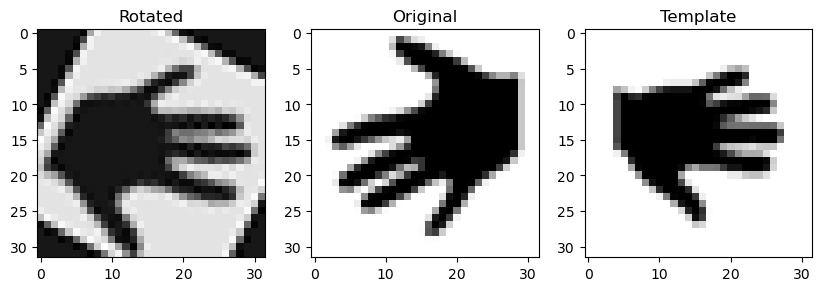

In [9]:
center = (W // 2, H // 2)
R = cv2.getRotationMatrix2D(center, angle_diff, 1.0)


rotated_original_image = cv2.warpAffine(original_image, R, (W, H), flags=cv2.INTER_CUBIC)
fig , axes = plt.subplots(1,3,figsize=(10,10))
axes[0].imshow(rotated_original_image , cmap='gray' )
axes[1].imshow(original_image , cmap='gray')
axes[2].imshow(template_image , cmap = 'gray')
axes[0].set_title('Rotated')
axes[1].set_title('Original')
axes[2].set_title('Template')



Text(0.5, 1.0, 'Template')

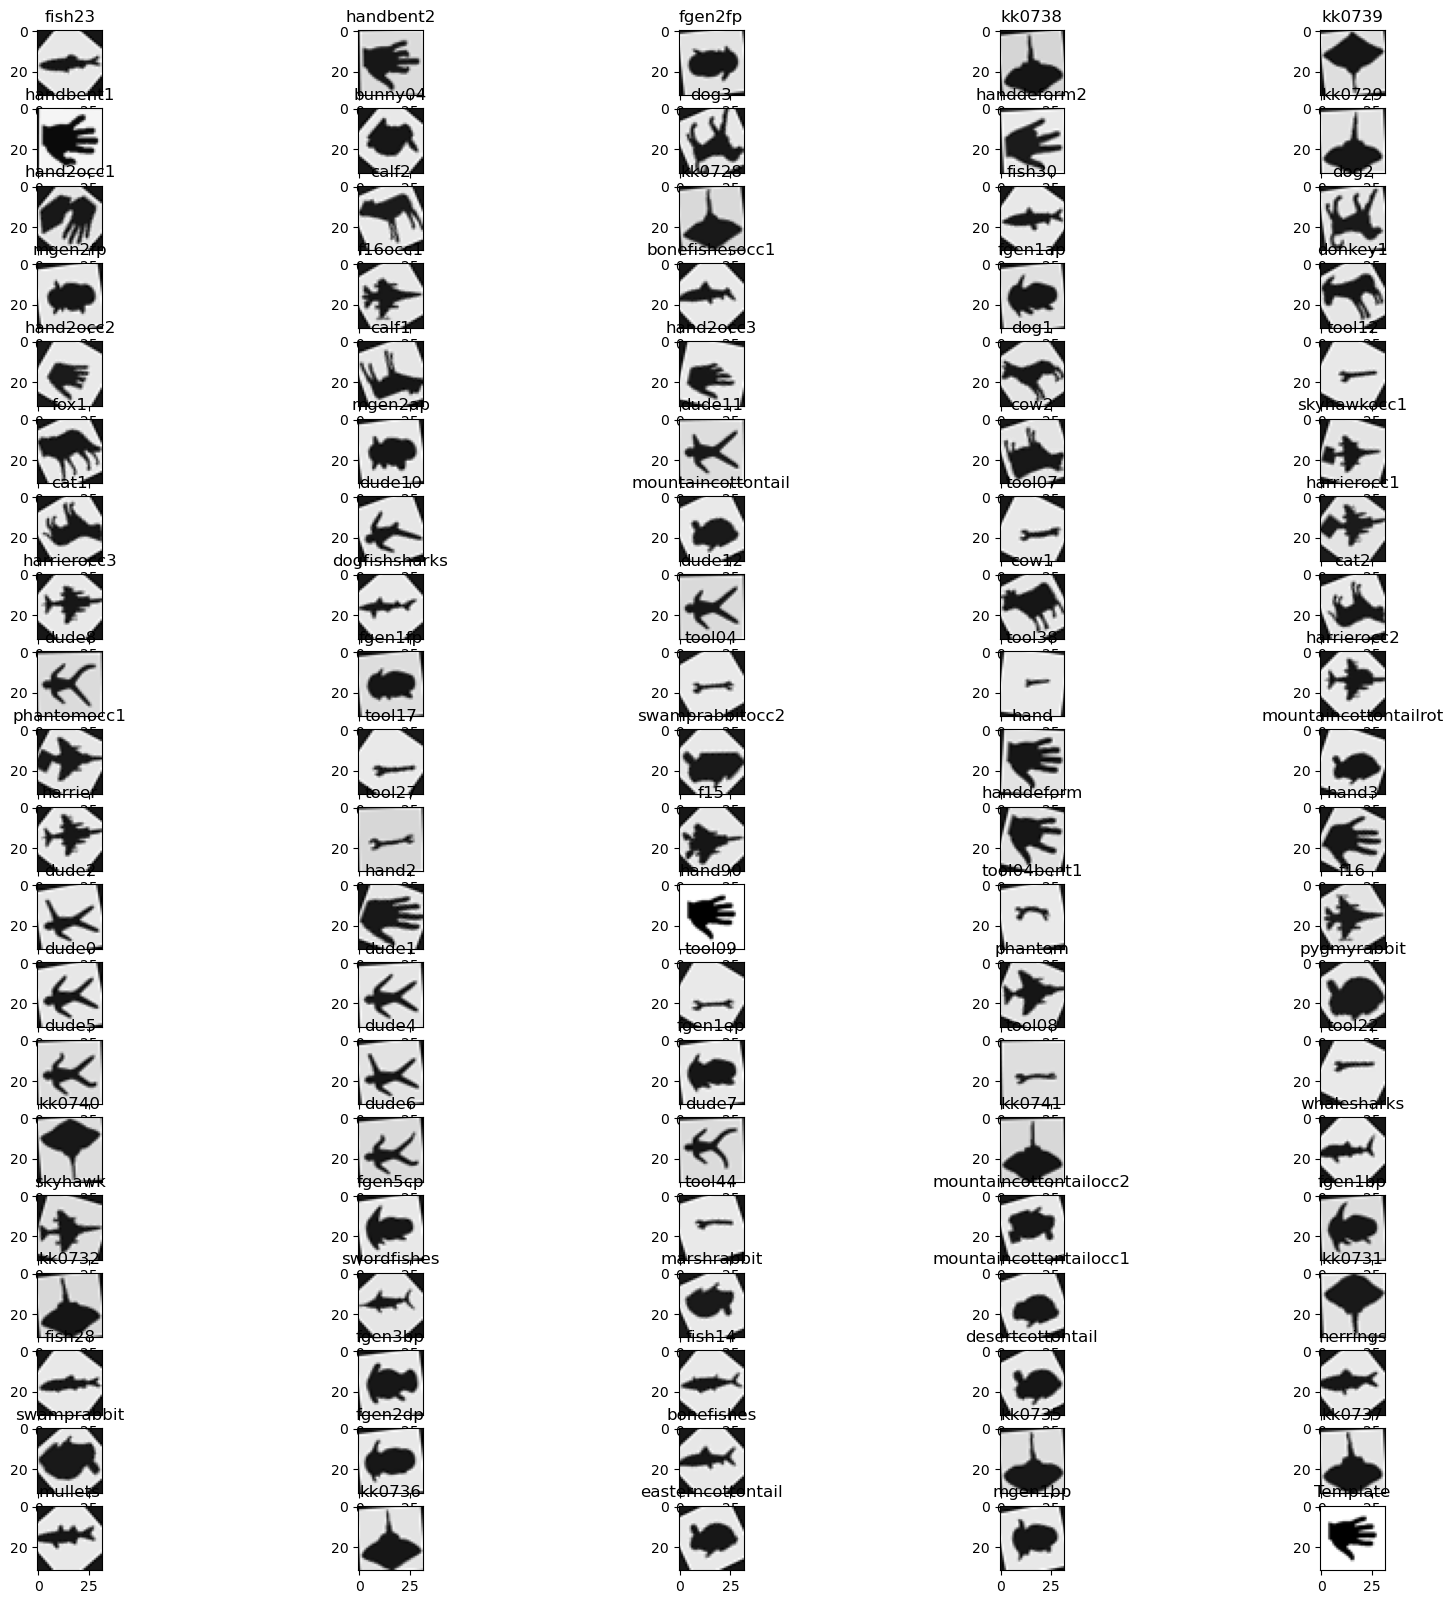

In [24]:
'''Now lets do it for a dataset of images'''
original_image_paths = os.listdir(data_dir)

def angle_find(image_path):
    image = load_image(os.path.join(data_dir,image_path))
    x , y = np.where(image == 0)

    feature_pts = np.array([x,y]).T
    pca = PCA(n_components=2)
    pca_feature_pts = pca.fit_transform(feature_pts)

    angle_orig = np.arctan2(pca.components_[0,1],pca.components_[0,0])
    angle_diff = -(angle_orig - angle_template)
    angle_diff = np.rad2deg(angle_diff)
    return angle_diff

fig , axes = plt.subplots((len(original_image_paths)+1)//5 ,5,figsize=(20,20))
for i in range(len(original_image_paths)):
    path = original_image_paths[i]
    angle_ = angle_find(path)
    R = cv2.getRotationMatrix2D(center, angle_, 1.0)
    image = load_image(os.path.join(data_dir,path))
    rotated_original_image = cv2.warpAffine(image, R, (W, H), flags=cv2.INTER_CUBIC)
    axes[i//5][i%5].imshow(rotated_original_image , cmap='gray' )
    axes[i//5][i%5].set_title(path.split('.')[0])


axes[(len(original_image_paths)+1)//5 - 1][4].imshow(template_image , cmap = 'gray')
axes[(len(original_image_paths)+1)//5 - 1][4].set_title('Template')